In [1]:
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, get_scheduler, BertTokenizer
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import ast

In [ ]:
# Load the dataset
file_path = r"Data\preprocess_with_translate.csv"
dataset0 = pd.read_csv(file_path)
dataset = dataset0.copy()

In [3]:
# Function to tokenize using IndoBERT
def tokenize_text(text, tokenizer):
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=128)
    return tokens['input_ids']
# Initialize IndoBERT tokenizer
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Ensure `cleaned_text` is of type `str`
dataset['cleaned_text'] = dataset['cleaned_text'].astype(str)

# Apply tokenization
dataset['tokenized_text'] = dataset['cleaned_text'].apply(lambda x: tokenize_text(x, tokenizer))

In [4]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the labels
dataset['encoded_label'] = label_encoder.fit_transform(dataset['label'])

# Print the mapping of labels to integers
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Demografi': 0, 'Ekonomi': 1, 'Geografi': 2, 'Ideologi': 3, 'Pertahanan dan Keamanan': 4, 'Politik': 5, 'Sosial Budaya': 6, 'Sumber Daya Alam': 7}


In [5]:
# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(dataset['tokenized_text'], dataset['encoded_label'], test_size=0.2, random_state=42)

class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.texts.iloc[idx], dtype=torch.long),  # Ensure input_ids are of type long
            'attention_mask': torch.tensor([1] * len(self.texts.iloc[idx]), dtype=torch.long)  # Ensure attention_mask is of type long
        }
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)  # Ensure labels are of type long
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_texts, train_labels)
val_dataset = TweetDataset(val_texts, val_labels)

In [6]:
# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

# Load model and move to GPU
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=8)
model.to(device)

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Assuming you have 5000 samples and you're using a batch size of 16
# total_train_steps = math.ceil(len(train_texts) / 16) * 3  # 3 epochs
# warmup_steps = int(0.1 * total_train_steps)  # 10% of the total training steps

training_args = TrainingArguments(
    output_dir=r"IndoBERT-p1\results",  
    num_train_epochs=10,                                               
    per_device_train_batch_size=32,                                   
    per_device_eval_batch_size=32,                                    
    learning_rate=3e-5,
    warmup_steps=0,                                                    # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                                                 # strength of weight decay
    logging_dir=r"IndoBERT-p1\logs",     
    logging_steps=10,                                                  # logs will be recorded every 10 steps
    max_grad_norm=1.0                                                  # Gradient clipping
)

In [8]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    balanced_acc = balanced_accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'balanced_accuracy': balanced_acc,
        'confusion_matrix': cm
    }

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=training_args.learning_rate)

# Calculate total steps and warm-up steps
total_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs
warmup_steps = int(total_steps * 0.1)  # Warmup for 10% of the total steps

# Create the linear warm-up scheduler
warmup_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# Initialize the Trainer with both schedulers
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, warmup_scheduler)
)

In [9]:
trainer.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


{'loss': 2.0326, 'grad_norm': 12.856722831726074, 'learning_rate': 2.4000000000000003e-06, 'epoch': 0.08}
{'loss': 1.6123, 'grad_norm': 4.688408851623535, 'learning_rate': 4.800000000000001e-06, 'epoch': 0.16}
{'loss': 1.3826, 'grad_norm': 3.7350473403930664, 'learning_rate': 7.2e-06, 'epoch': 0.24}
{'loss': 1.4293, 'grad_norm': 3.0192275047302246, 'learning_rate': 9.600000000000001e-06, 'epoch': 0.32}
{'loss': 1.249, 'grad_norm': 5.729355812072754, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 1.3275, 'grad_norm': 3.2127811908721924, 'learning_rate': 1.44e-05, 'epoch': 0.48}
{'loss': 1.3818, 'grad_norm': 2.8748457431793213, 'learning_rate': 1.6800000000000002e-05, 'epoch': 0.56}
{'loss': 1.3014, 'grad_norm': 4.040222644805908, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.64}
{'loss': 1.3155, 'grad_norm': 4.891315937042236, 'learning_rate': 2.16e-05, 'epoch': 0.72}
{'loss': 1.3391, 'grad_norm': 4.366336822509766, 'learning_rate': 2.4e-05, 'epoch': 0.8}
{'loss': 1.2257, 'grad_

TrainOutput(global_step=1250, training_loss=0.35166295790672303, metrics={'train_runtime': 574.0034, 'train_samples_per_second': 69.686, 'train_steps_per_second': 2.178, 'total_flos': 2631252295680000.0, 'train_loss': 0.35166295790672303, 'epoch': 10.0})

In [10]:
results = trainer.evaluate()

  0%|          | 0/32 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[[  2   0   0   0   1   8   2   0]
 [  1  40   0   0   0  10   4   4]
 [  1   1   0   0   0   0   2   0]
 [  0   1   0  42   1  29   6   2]
 [  0   0   0   0  79  16   1   0]
 [  1   9   0  11  19 515  28   3]
 [  0   1   0   1   1  35  81   1]
 [  0   5   2   0   0   6   8  20]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


In [11]:
print(f"Accuracy: {results['eval_accuracy']}\n")
print(f"Balanced Accuracy: {results['eval_balanced_accuracy']}")

Accuracy: 0.779

Balanced Accuracy: 0.5268614886523401


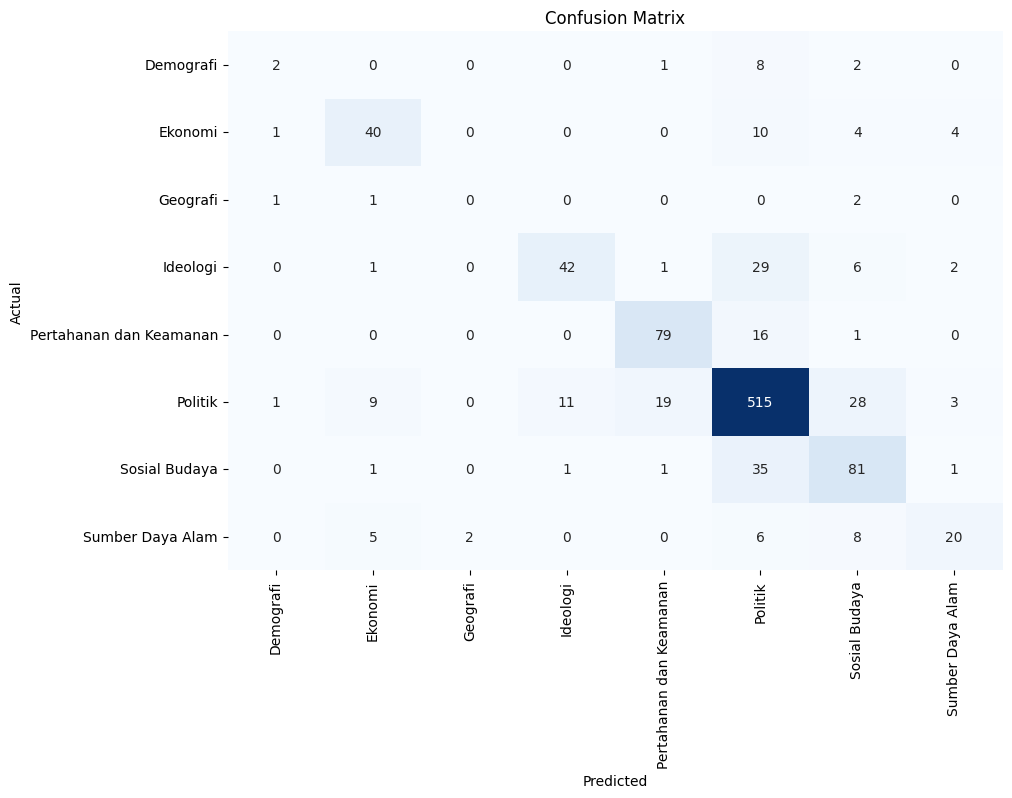

In [12]:
# Assuming 'label_encoder' and 'results' are already defined
cm = results['eval_confusion_matrix']
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Predict Submission

In [ ]:
# Load the dataset
file_path = r"Data\unlabeled_preprocess_with_translate.csv"
dataset0 = pd.read_csv(file_path)
dataset = dataset0.copy()

In [44]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

def tokenize_text(text, tokenizer):
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
    return tokens['input_ids'][0].tolist(), tokens['attention_mask'][0].tolist()

dataset[['tokenized_text', 'attention_mask']] = dataset['cleaned_text'].apply(
    lambda x: pd.Series(tokenize_text(x, tokenizer))
)

In [45]:
dataset

,IDText,Text,cleaned_text,tokenized_text,attention_mask
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,inginkah orang orang pro demokrasi di negeri i...,"[2, 561, 1721, 232, 232, 2023, 4982, 26, 1202,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya soal hutang luar negeri dia me...,"[2, 11283, 7504, 1495, 8133, 892, 1202, 364, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,TXT0003,kikidaliyo Ganjar Pranowo itulah beliau sosok ...,kikidaliyo ganjar pranowo itulah beliau sosok ...,"[2, 23613, 11550, 8377, 30370, 18006, 30359, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran yang bisa melakukan itu semua d...,"[2, 11283, 19044, 3823, 34, 166, 464, 137, 366...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
4,TXT0005,@sniperruben45 @udazulhendra @ainunnajib Lah j...,lah justru yang enggak menyambung junjungan lu...,"[2, 1389, 2814, 34, 6878, 19281, 4687, 19678, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
995,TXT0996,Bikin bangga deh Ganjar-Mahfud mau alokasikan ...,bikin bangga deh ganjar mahfud mau alokasikan ...,"[2, 2999, 4988, 2983, 18006, 30359, 20469, 422...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,pak jokowi sebelum pilpres berbesar hati meran...,"[2, 556, 5237, 560, 15140, 399, 331, 1268, 222...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,sebaiknya sih gemot enggak usah ikutan debat d...,"[2, 2525, 1966, 5536, 105, 6878, 3370, 10384, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk atau bermusyawarah jadi gay...,"[2, 3855, 28311, 70, 158, 18438, 9691, 472, 22...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [46]:
class UnlabeledTweetDataset(torch.utils.data.Dataset):
    def __init__(self, texts, attention_masks):
        self.texts = texts
        self.attention_masks = attention_masks

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.texts[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.texts)

# Create the dataset
texts = dataset['tokenized_text'].tolist()
attention_masks = dataset['attention_mask'].tolist()

unlabeled_dataset = UnlabeledTweetDataset(texts, attention_masks)

In [47]:
# Define the class dictionary
class_dict = {'Demografi': 0, 'Ekonomi': 1, 'Geografi': 2, 'Ideologi': 3, 'Pertahanan dan Keamanan': 4, 'Politik': 5, 'Sosial Budaya': 6, 'Sumber Daya Alam': 7}

# Invert the dictionary to map numerical labels to class names
inv_class_dict = {v: k for k, v in class_dict.items()}

# Use the Trainer to make predictions
predictions = trainer.predict(unlabeled_dataset)

# Get the predicted labels
predicted_labels = predictions.predictions.argmax(-1)

# Map numerical predictions to class names
predicted_class_names = [inv_class_dict[label] for label in predicted_labels]

# Convert to DataFrame
predictions_df = pd.DataFrame(predicted_class_names, columns=['predicted_label'])
print(predictions_df.head())

  0%|          | 0/32 [00:00<?, ?it/s]

  predicted_label
0         Politik
1         Politik
2        Ideologi
3         Politik
4         Politik


In [ ]:
# Optionally, save predictions to a CSV file
predictions_df.to_csv(r"Submission\submission_1.csv", index=False)